## Introduction

Hey there! Welcome to the fourth blog post of Python for Beginners! Today, we’re diving into an exciting project — building a Simple Message Bank using Dash and SQLite. If you've ever wanted to create an interactive web app where users can submit and view random messages, you’re in the right place!

By the end of this tutorial, you’ll have a fully functional message board that lets users submit messages and randomly view them—because who doesn’t love a little mystery? 

Let’s get coding!

### Step 1: Creating the Database

First, we need a way to store and retrieve messages. That’s where SQLite comes in! Let’s import our necessary libraries, initialize the Dash app and create a function to initialize the database:

In [ ]:
# Import necessary libraries
import sqlite3
import dash
from dash import dcc, html, Input, Output, State

In [ ]:
# Initialize the Dash app
app = dash.Dash(__name__)
server = app.server

In [ ]:
# Function to get or create the message database
def get_message_db():
    """
    Connects to the SQLite database or creates it if it doesn't exist.
    Ensures that the 'messages' table is set up properly.
    """
    # Check for database (message_db) defined in global scope
    global message_db
    # If defined, return
    if 'message_db' in globals():
        return message_db
    # If not, connect to database and assign to global variable "message_db"
    else:
        db = sqlite3.connect("messages_db.sqlite", check_same_thread=False)
        cursor = db.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS messages (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                handle TEXT NOT NULL,
                message TEXT NOT NULL
            )
        """)
        db.commit()
        return db

#### What’s Happening Here?
- We check if the database is already open (so we don’t make multiple connections).
- If not, we connect to SQLite and create a table named messages to store user-submitted messages.
- We AUTOINCREMENT the id (because who wants to manually track message IDs?).

### Step 2: Inserting Messages
Now, let’s allow users to submit messages! We need a function that will take the user’s name and message, then save it to our database.

This function grabs our database, inserts a new row with the user’s handle and message, and then commits & closes the connection.

In [ ]:
# Insert Message Into Database
def insert_message(handle, message):
    """
    Inserts a new message into the database.
    
    Parameters:
        handle (str): The name or handle of the user.
        message (str): The message content.
    """
    db = get_message_db()
    cursor = db.cursor()
    # Insert message into database
    cursor.execute("INSERT INTO messages (handle, message) VALUES (?, ?)", (handle, message))
    db.commit()
    db.close()

### Step 3: Retrieving Random Messages

Instead of displaying all messages in order, let’s randomly grab a few—because life is more exciting when it’s unpredictable, right?

- Fetches 5 random messages (or fewer if there aren’t that many)
- Uses SQLite’s ORDER BY RANDOM() to shuffle things up! 
- Closes the database connection

In [ ]:
# Retrieve random messages from the database
def random_messages(n=5):
    """
    Retrieves up to n random messages from the database.
    
    Parameters:
        n (int): Number of random messages to retrieve (default is 5).
    
    Returns:
        list of tuples: Each tuple contains (handle, message).
    """
    db = get_message_db()
    cursor = db.cursor()
    cursor.execute("SELECT handle, message FROM messages ORDER BY RANDOM() LIMIT ?", (n,))
    messages = cursor.fetchall()
    db.close()
    return messages

### Step 4: Designing the Web App
Now this is where the fun is - getting to customize our webpage however we want! In this tutorial, I want to keep it in the theme of pink, navy and light gray.

- Centered layout with a light gray background.
- Pink buttons because… why not?
- Rounded corners for that soft, modern look.

In [ ]:
# Layout
app.layout = html.Div(style={
    'font-family': 'Times New Roman, serif',
    'text-align': 'center',
    'background-color': '#F3F3F3',  # Light gray background
    'height': '100vh',
    'display': 'flex',
    'flex-direction': 'column',
    'justify-content': 'center',
    'align-items': 'center'
}, children=[
    html.H1("A SIMPLE MESSAGE BANK", style={'color': 'navy', 'font-weight': 'bold'}),

    html.Div(style={
        'background-color': 'white',
        'padding': '20px',
        'border-radius': '10px',
        'box-shadow': '0px 4px 10px rgba(0, 0, 0, 0.1)',
        'width': '50%',
        'text-align': 'left'
    }, children=[
        html.H3("Submit", style={'font-family': 'Times New Roman, serif', 'color': 'navy'}),
        html.Label("Your Message:", style={'color': 'black'}),
        dcc.Input(id='message', type='text', placeholder='Enter your message',
                  style={'font-family': 'Times New Roman, serif', 'width': '100%', 'padding': '8px', 'margin-bottom': '10px', 'border-radius': '5px', 'border': '1px solid lightgray'}),
        
        html.Label("Your Name or Handle:", style={'color': 'black'}),
        dcc.Input(id='handle', type='text', placeholder='Enter your name',
                  style={'font-family': 'Times New Roman, serif', 'width': '100%', 'padding': '8px', 'margin-bottom': '10px', 'border-radius': '5px', 'border': '1px solid lightgray'}),
        
        html.Button('Submit', id='submit-button', n_clicks=0, style={
            'font-family': 'Times New Roman, serif',
            'background-color': 'pink',
            'color': 'white',
            'border': 'none',
            'padding': '10px 15px',
            'border-radius': '5px',
            'cursor': 'pointer'
        }),
        html.Div(id='confirmation', style={'margin-top': '10px', 'color': 'green'})
    ]),

    html.H3("View", style={'color': 'navy', 'margin-top': '20px'}),
    html.Ul(id='messages-list', style={'list-style-type': 'none', 'padding': 0}),

    html.Button('Update', id='update-button', n_clicks=0, style={
        'font-family': 'Times New Roman, serif',
        'background-color': 'pink',
        'color': 'white',
        'border': 'none',
        'padding': '10px 15px',
        'border-radius': '5px',
        'cursor': 'pointer',
        'margin-top': '10px'
    }),
])

### Step 5: Making the Web App Interactive

Now, let’s wire up the buttons! We need two callbacks:

- One for submitting messages.

In [ ]:
# Callback for submitting messages
@app.callback(
    Output('confirmation', 'children'),
    Input('submit-button', 'n_clicks'),
    [State('handle', 'value'), State('message', 'value')]
)

def submit(n_clicks, handle, message):
    """
    Handles message submission when the submit button is clicked.
    
    Parameters:
        n_clicks (int): Number of button clicks.
        handle (str): User's handle/name.
        message (str): User's message.
    
    Returns:
        str: Confirmation message upon successful submission.
    """
    if n_clicks > 0 and handle and message:
        insert_message(handle, message)
        return "Thanks for submitting a message!"
    return ""

- One for fetching random messages when users hit "Update".

In [ ]:
# Callback for updating the view with random messages
@app.callback(
    Output('messages-list', 'children'),
    Input('update-button', 'n_clicks')
)

def view(n_clicks):
    """
    Gets and displays random messages when the update button is clicked.
    
    Parameters:
        n_clicks (int): Number of button clicks.
    
    Returns:
        list: A list of HTML list items containing messages.
    """
    messages = random_messages(5)
    return [html.Li(html.I(f"{h}: {m}"), style={'color': 'black', 'margin-bottom': '5px'}) for h, m in messages]

### Running the Web App
Add this last piece of code to get your web app up and running!

In [ ]:
if __name__ == "__main__":
    app.run_server(debug=True, port=8060)

### Screenshots
- Here is an example of the user submitting a message and in the handle field, they can use either their name or their GitHub handle.

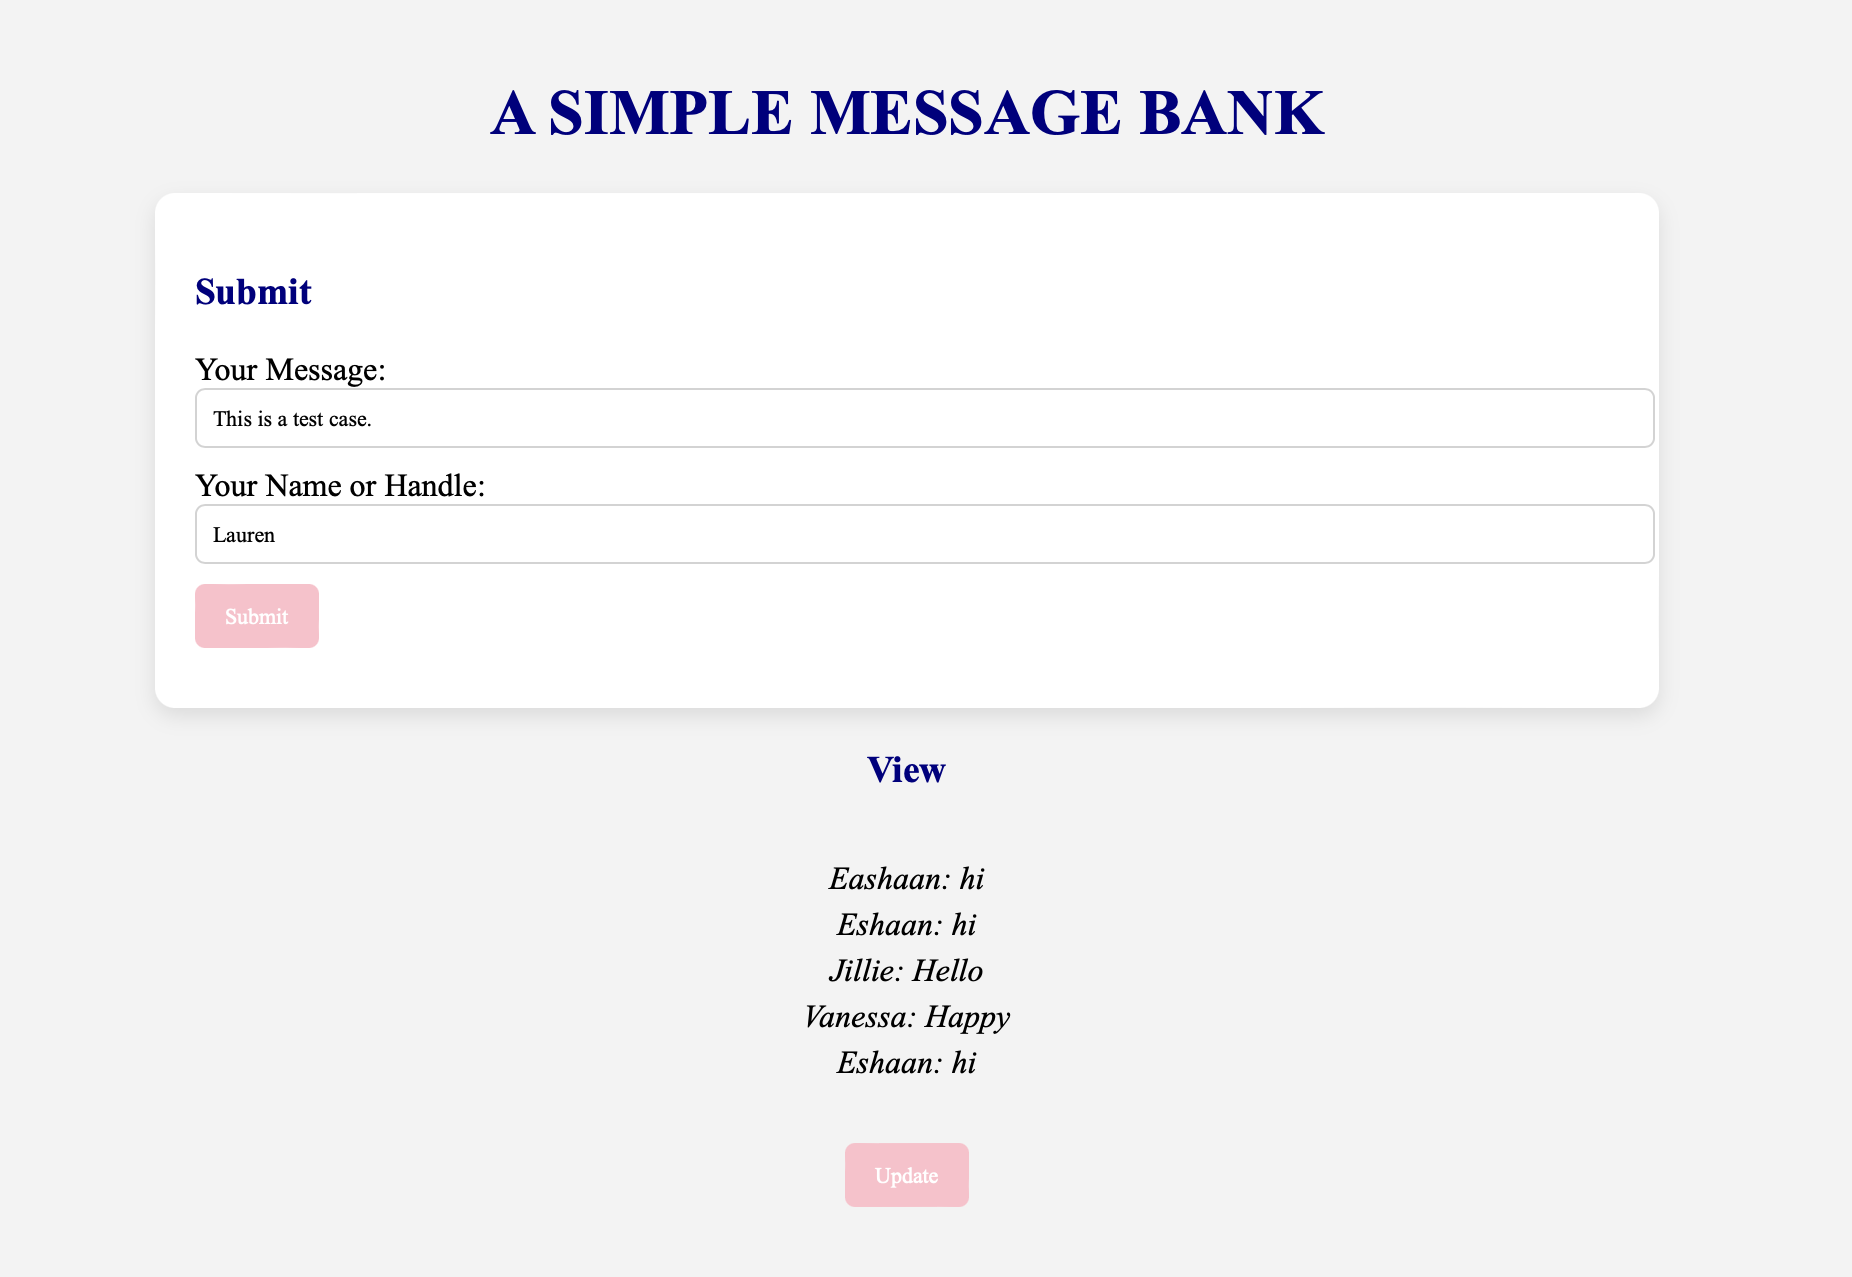

In [12]:
from IPython.display import display, Image

display(Image("pic1.png"))

- Here is an example of a user viewing submitted messages. Show at least two messages, one of which is the message you submitted in the previous screencap. This message should show your name or GitHub handle.

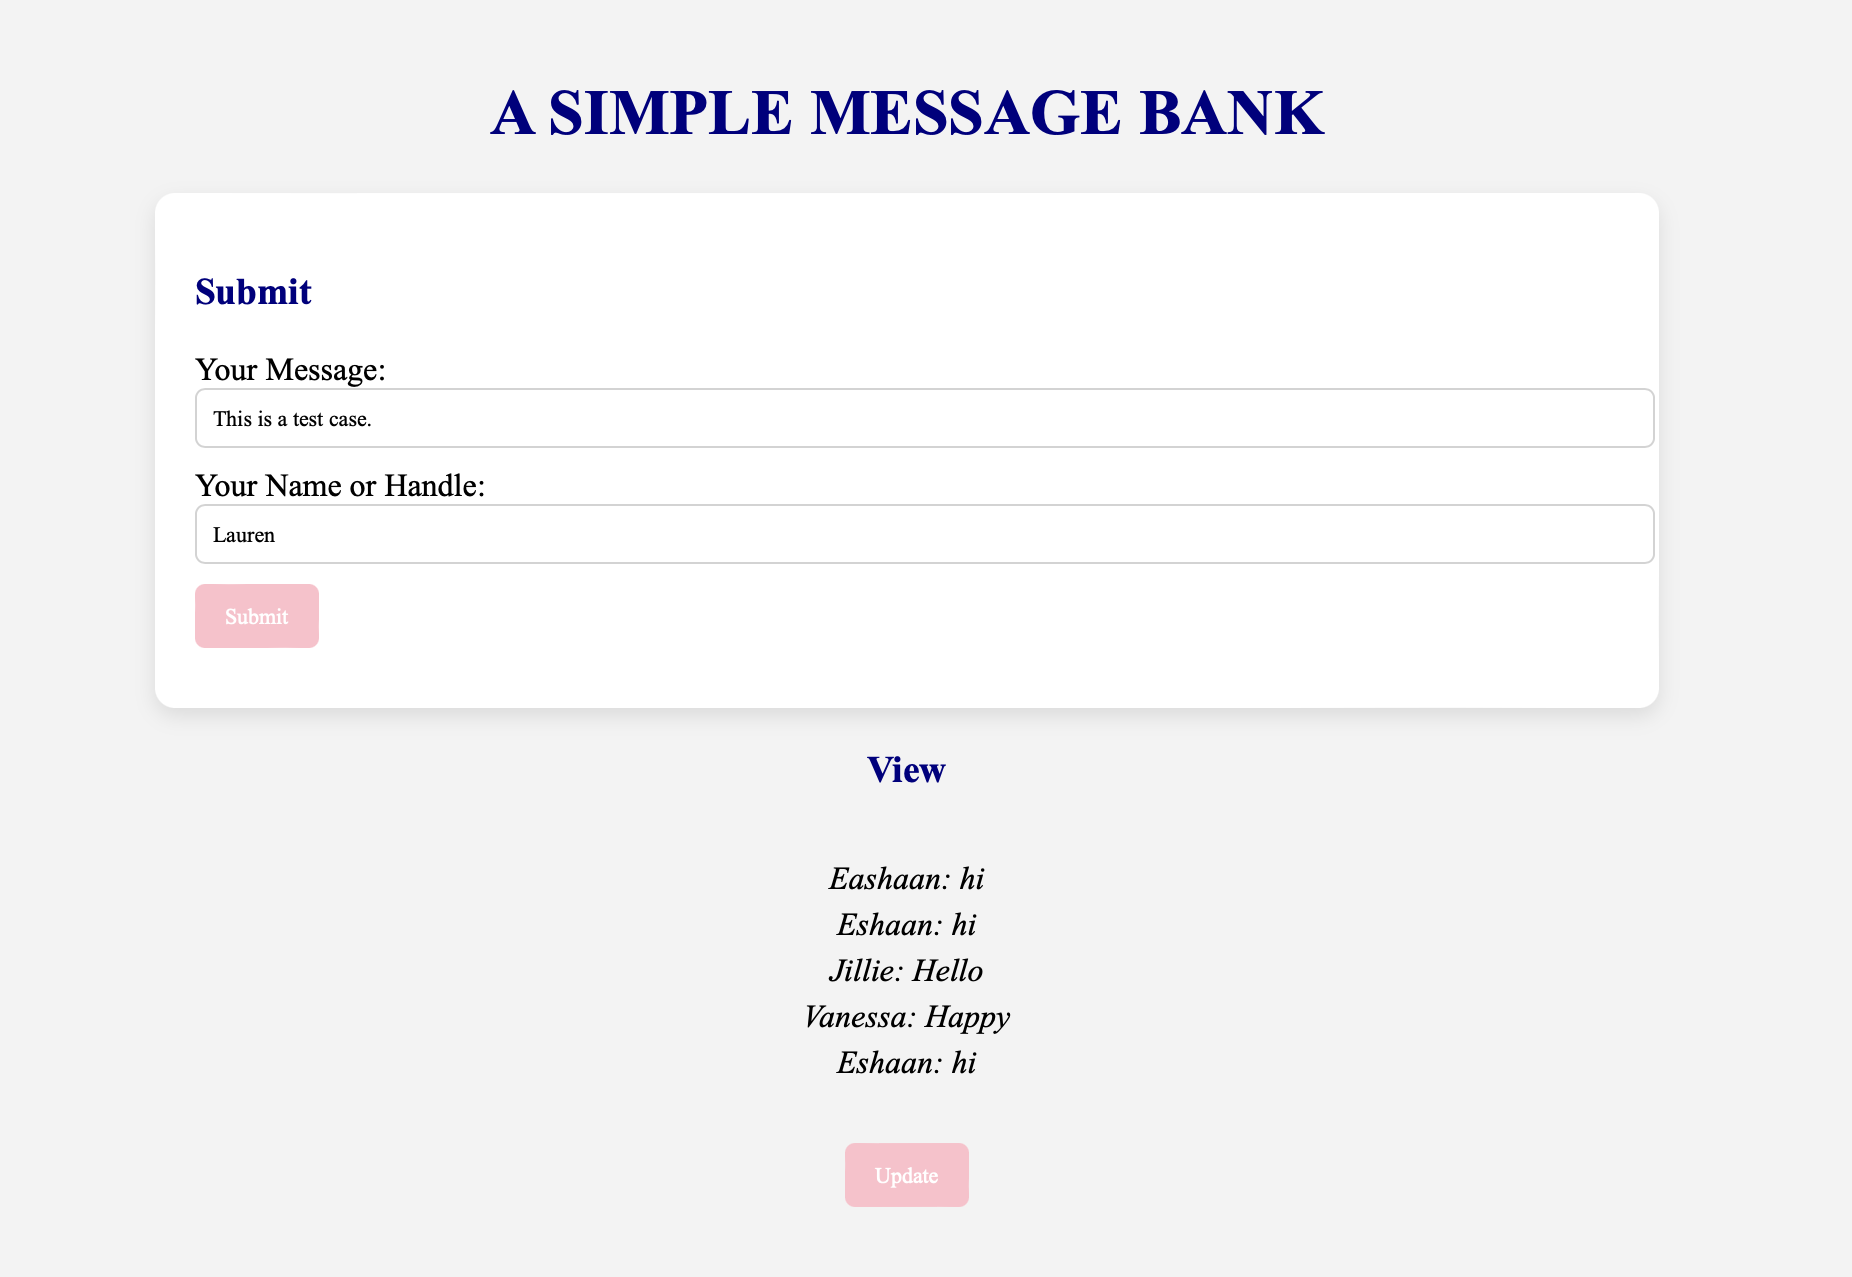

In [13]:
display(Image("pic1.png"))

### Conclusion

And that wraps it up for our Python for Beginners: Building a Web App with Dash!